<a href="https://colab.research.google.com/github/nicikess/hsg-nlp-course/blob/main/notebooks/06_Vanishing_Gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from dataclasses import dataclass
from time import perf_counter

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.style.use('ggplot')

In [ ]:
# Data Parameters
N_EXAMPLES_PER_CLASS = 100
N_FEATURES = 2
N_CLASSES = 3

# Hyper Parameters
N_HIDDEN_1 = 50
N_HIDDEN_2 = 50

# Optimizer
LEARNING_RATE = 1e-1
N_EPOCHS = 50_000

# Regularization
REGULARIZATION_RATE = 1e-3

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Will use: {device}")

Will use: cuda


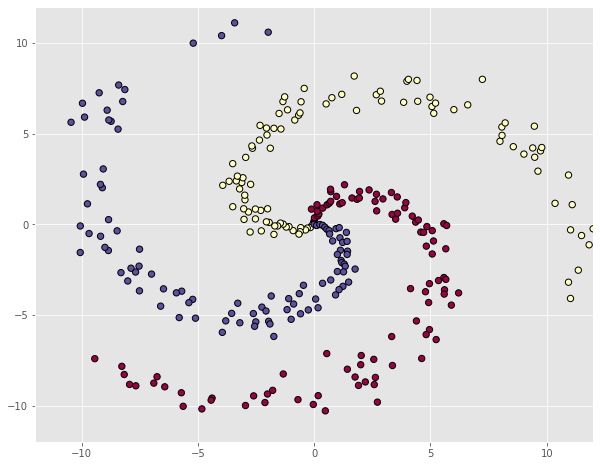

In [ ]:
#generate random data -- not linearly separable 
torch.random.manual_seed(0)

X = torch.zeros((N_EXAMPLES_PER_CLASS * N_CLASSES, N_FEATURES))
y = torch.zeros(N_EXAMPLES_PER_CLASS * N_CLASSES, dtype=torch.long)

for j in range(N_CLASSES):
    ix = torch.arange(N_EXAMPLES_PER_CLASS * j, N_EXAMPLES_PER_CLASS * (j + 1))
    r = torch.linspace(0.0, 12, N_EXAMPLES_PER_CLASS) # radius
    t = torch.linspace(j*4, (j + 1) * 4, N_EXAMPLES_PER_CLASS) + torch.torch.randn(N_EXAMPLES_PER_CLASS) * 0.2 # theta
    X[ix] = torch.stack((r * torch.sin(t), r * torch.cos(t)), dim=1)
    y[ix] = j

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, marker='o', linewidths=1, edgecolors='black')
ax.set_xlim([-12,12])
ax.set_ylim([-12,12])

plt.show()

In [ ]:
class ThreeLayers(nn.Module):
    
    def __init__(self, nonlinearity_fn: nn.Module, n_inputs: int, n_hidden_1: int, n_hidden_2: int, n_outputs: int):
        super().__init__()
        
        self.hidden_1_W = nn.Parameter(0.1 * torch.randn(n_inputs, n_hidden_1))
        self.hidden_1_b = nn.Parameter(torch.zeros(n_hidden_1))
        self.hidden_1_activation = nonlinearity_fn
        
        self.hidden_2_W = nn.Parameter(0.1 * torch.randn(n_hidden_1, n_hidden_2))
        self.hidden_2_b = nn.Parameter(torch.zeros(n_hidden_2))
        self.hidden_2_activation = nonlinearity_fn
        
        self.output_W = nn.Parameter(0.1 * torch.randn(n_hidden_2, n_outputs))
        self.output_b = nn.Parameter(torch.zeros(n_outputs))
    
    def forward(self, inputs):
        h1 = self.hidden_1_activation(torch.matmul(inputs, self.hidden_1_W) + self.hidden_1_b)
        h2 = self.hidden_2_activation(torch.matmul(h1, self.hidden_2_W) + self.hidden_2_b)
        scores = torch.matmul(h2, self.output_W) + self.output_b
        exp_scores = torch.exp(scores)
        probs = exp_scores / exp_scores.sum(dim=1, keepdim=True)
        return probs

In [ ]:
@dataclass(slots=True)
class TrainedModel:
    model: nn.Module
    losses: list[float]
    gradient_updates: dict[str, list[float]]
    accuracies: list[float]
    durations: list[float]

In [ ]:
def loss_fn(model, y_pred, y_true, reg: float):
    num_examples = y_true.shape[0]

    correct_logprobs = - torch.log(y_pred[torch.arange(num_examples), y_true])
    
    data_loss = correct_logprobs.sum() / num_examples
    
    reg_loss = 0.0
    reg_loss += 0.5 * reg * torch.sum(model.hidden_1_W * model.hidden_1_W)
    reg_loss += 0.5 * reg * torch.sum(model.hidden_2_W * model.hidden_2_W)
    reg_loss += 0.5 * reg * torch.sum(model.output_W * model.output_W)
    
    loss = data_loss + reg_loss
    
    return loss

In [ ]:
def train_model(nonlinearity_fn: nn.Module, lr: float = LEARNING_RATE, reg: float = REGULARIZATION_RATE):
    model = ThreeLayers(
        nonlinearity_fn=nonlinearity_fn,
        n_inputs=N_FEATURES,
        n_hidden_1=N_HIDDEN_1,
        n_hidden_2=N_HIDDEN_1,
        n_outputs=N_CLASSES
    )
    
    # move everything (optionally) to GPU
    X_train = X.to(device)
    y_train = y.to(device)
    model = model.to(device)
    
    losses = []
    accuracies = []
    durations = []
    gradient_updates = {'hidden1': [], 'hidden2': []}
    
    for epoch in tqdm(range(N_EPOCHS)):
        
        epoch_started = perf_counter()
        
        # zero gradients
        if model.hidden_1_W.grad is not None:
            model.hidden_1_W.grad.zero_()
            model.hidden_1_b.grad.zero_()
            model.hidden_2_W.grad.zero_()
            model.hidden_2_b.grad.zero_()
            model.output_W.grad.zero_()
            model.output_b.grad.zero_()
        
        # forward pass
        y_pred = model(X_train)
        
        # compute loss
        loss = loss_fn(model, y_pred, y_train, reg=reg)
        losses.append(loss.cpu().item())
        
        # backward pass
        loss.backward()
        
        # Update weights
        with torch.no_grad():
            # Save sum of magnitudes per layer
            gradient_updates['hidden2'].append(
                (model.hidden_2_W.grad.abs().sum() / sum(model.hidden_2_W.grad.shape)).cpu().item()
            )
            gradient_updates['hidden1'].append(
                (model.hidden_1_W.grad.abs().sum() / sum(model.hidden_1_W.grad.shape)).cpu().item()
            )
        
            # regularize weights
            model.output_W.grad += reg * model.output_W
            model.hidden_2_W.grad += reg * model.hidden_2_W
            model.hidden_1_W.grad += reg * model.hidden_1_W
    
            # Gradient Descent
            model.hidden_1_W += -lr * model.hidden_1_W.grad
            model.hidden_1_b += -lr * model.hidden_1_b.grad
            model.hidden_2_W += -lr * model.hidden_2_W.grad
            model.hidden_2_b += -lr * model.hidden_2_b.grad
            model.output_W += -lr * model.output_W.grad
            model.output_b += -lr * model.output_b.grad
            
            # Add train accuracy
            predicted_classes = torch.argmax(y_pred, axis=1)
            accuracies.append(
                (torch.sum(predicted_classes == y_train) / len(predicted_classes)).cpu().item()
            )
        durations.append(perf_counter() - epoch_started)

    return TrainedModel(
        model=model.cpu(),
        losses=losses,
        accuracies=accuracies,
        gradient_updates=gradient_updates,
        durations=durations
    )

In [ ]:
def print_duration(durations):
    durations = np.array(durations)
    total = np.sum(durations)
    
    print(f"Average Epoch: {np.mean(durations)*1000:.2f}ms (± {np.std(durations)*1000:.2f}ms)")
    print(f"Epochs per second: {len(durations) / total:.0f}/s")
    print(f"Total duration: {total / 60:.2f} min")

In [ ]:
sigmoid_model = train_model(nonlinearity_fn=torch.sigmoid)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
print_duration(sigmoid_model.durations)

Average Epoch: 1.65ms (± 0.24ms)
Epochs per second: 607/s
Total duration: 1.37 min


In [ ]:
relu_model = train_model(nonlinearity_fn=F.relu)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
print_duration(relu_model.durations)

Average Epoch: 1.66ms (± 0.20ms)
Epochs per second: 603/s
Total duration: 1.38 min


In [ ]:
tanh_model = train_model(nonlinearity_fn=torch.tanh)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
print_duration(tanh_model.durations)

Average Epoch: 1.64ms (± 0.17ms)
Epochs per second: 609/s
Total duration: 1.37 min


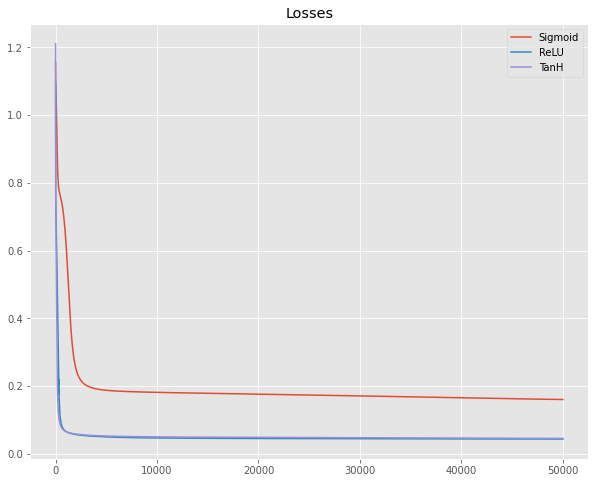

In [ ]:
fig, ax = plt.subplots()

ax.plot(sigmoid_model.losses, label='Sigmoid')
ax.plot(relu_model.losses, label='ReLU')
ax.plot(tanh_model.losses, label='TanH')

ax.legend()
ax.set_title('Losses')

plt.show()

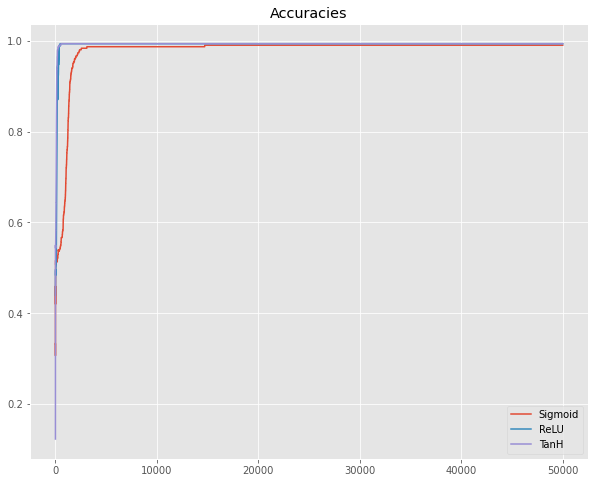

In [ ]:
fig, ax = plt.subplots()

ax.plot(sigmoid_model.accuracies, label='Sigmoid')
ax.plot(relu_model.accuracies, label='ReLU')
ax.plot(tanh_model.accuracies, label='TanH')

ax.legend()
ax.set_title('Accuracies')

plt.show()

In [ ]:
def plot_gradient_updates(model: TrainedModel, title:str):
    fig, ax = plt.subplots()
    
    ax.plot(model.gradient_updates['hidden1'], label='First Layer')
    ax.plot(model.gradient_updates['hidden2'], label='Second Layer')
    
    ax.legend()
    ax.set_title(title)
    
    plt.show()

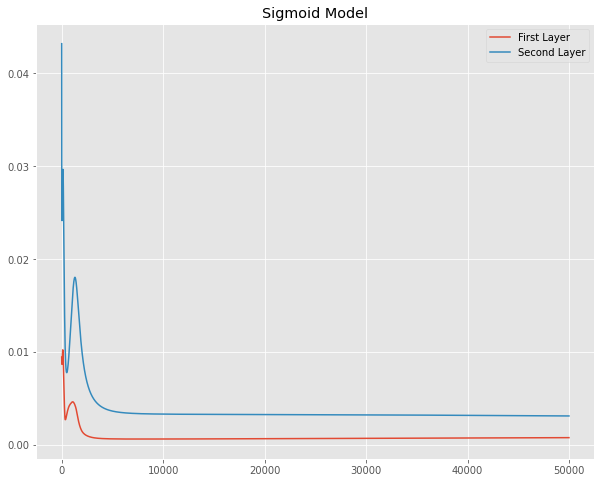

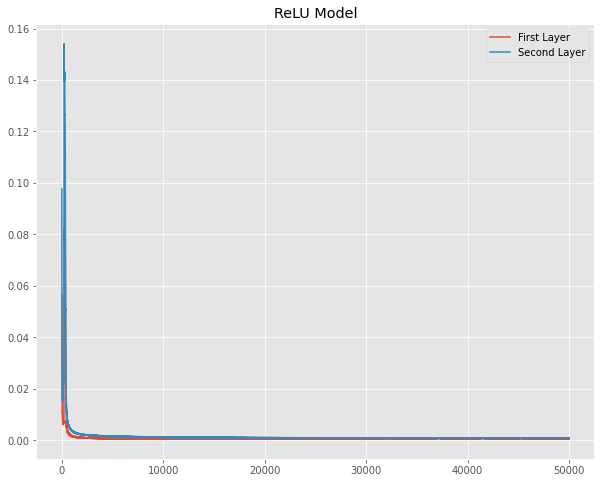

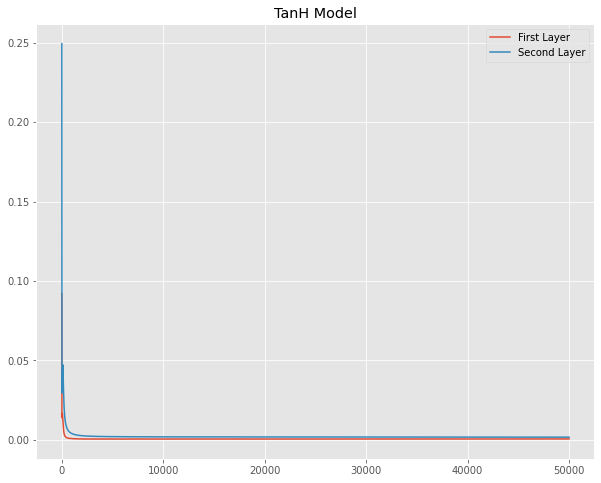

In [ ]:
plot_gradient_updates(sigmoid_model, title='Sigmoid Model')
plot_gradient_updates(relu_model, title='ReLU Model')
plot_gradient_updates(tanh_model, title='TanH Model')

In [ ]:
def plot_classifier(model: TrainedModel, title:str):
    h = 0.02

    x_min = X[:, 0].min() - 1
    x_max = X[:, 0].max() + 1

    y_min = X[:, 1].min() - 1
    y_max = X[:, 1].max() + 1

    xx, yy = torch.meshgrid(
        torch.arange(x_min, x_max, h),
        torch.arange(y_min, y_max, h),
        indexing='xy'
    )
    model.model.eval()
    with torch.no_grad():
        Z = model.model(torch.stack((xx.ravel(), yy.ravel()), dim=1))
        Z = torch.argmax(Z, axis=1).view(xx.shape)

    fig, ax = plt.subplots()

    ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, marker='o', linewidths=1, edgecolors='black')
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    ax.set_title(title)
    
    plt.show()

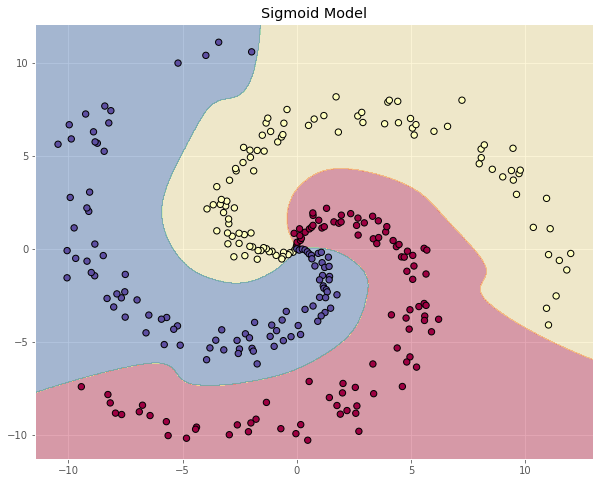

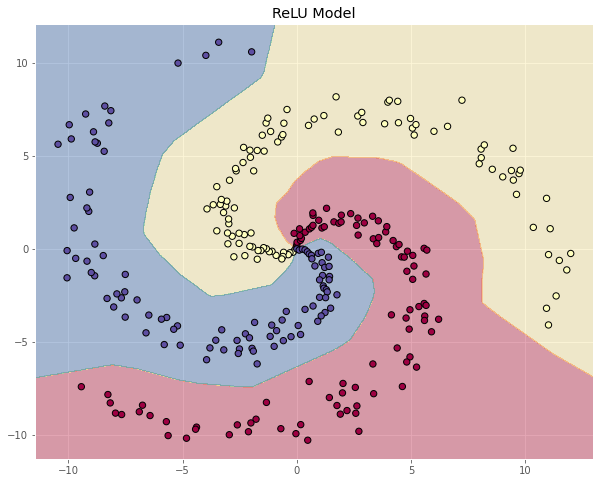

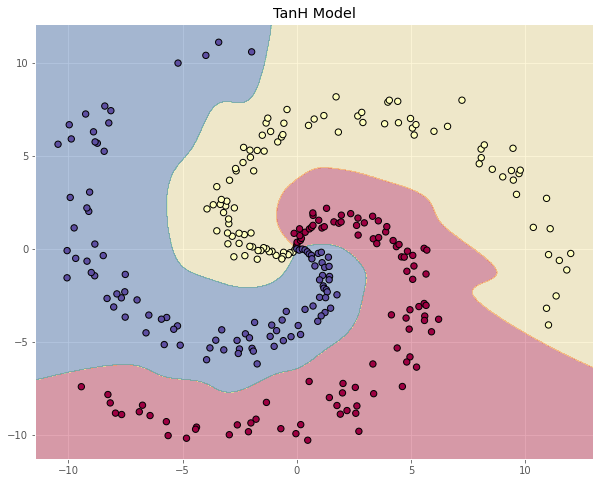

In [ ]:
plot_classifier(sigmoid_model, title='Sigmoid Model')
plot_classifier(relu_model, title='ReLU Model')
plot_classifier(tanh_model, title='TanH Model')